# Seq2Seq Modeling for Joint Angle Prediction

In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import sys
sys.path.insert(0, '..')

from pathlib import Path
import math, random, time, os

import torch
from torch import nn, optim, Tensor
import torch.nn.functional as F

import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker

from common.data_utils import *
from common.models import *
from common.training_utils import *

torch.manual_seed(0)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data Management

In [11]:
data_path = Path('../csv-files')
filenames = os.listdir(data_path)

joint_requests = {'Joint' : ['jL5S1','jL4L3','jL1T12','jT9T8','jT1C7','jC1Head',
                             'jRightC7Shoulder','jRightShoulder','jRightElbow','jRightWrist',
                             'jLeftC7Shoulder','jLeftShoulder','jLeftElbow','jLeftWrist',
                             'jRightHip','jRightKnee','jRightAnkle','jRightBallFoot',
                             'jLeftHip','jLeftKnee','jLeftAnkle','jLeftBallFoot']}
num_files = 2
seq_length = 120

In [13]:
joint_angles, scaler = read_data(filenames, data_path, num_files, joint_requests, seq_length)

Done with reading files
Number of frames in dataset: 537360
Number of bytes: 283726080


In [15]:
encoder_input_data, decoder_target_data = split_sequences(joint_angles, seq_length=seq_length)
del data

batch_size = 32
encoder_input_data = discard_remainder(encoder_input_data, batch_size)
decoder_target_data = discard_remainder(decoder_target_data, batch_size)

## Refactor using Dataset and DataLoader

In [7]:
from torch.utils.data import TensorDataset, DataLoader, random_split

In [8]:
encoder_input_data = torch.tensor(encoder_input_data).to(device)
decoder_target_data = torch.tensor(decoder_target_data).to(device)

In [9]:
dataset = TensorDataset(encoder_input_data, decoder_target_data)

train_size_approx = int(0.8 * len(dataset))
train_size = train_size_approx - (train_size_approx % batch_size)
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [11]:
print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(val_dataset))

Number of training samples: 3552
Number of validation samples: 896


## Zero-Velocity Baseline

In [12]:
def zero_velocity_baseline(data, criterion):
    loss = 0
    
    input_batch, target_batch = data

    seq_length = input_batch.shape[1]
    
    last_input = input_batch[:, -1, :].unsqueeze(0).float()
    
    for t in range(seq_length):
        target = target_batch[:, t, :].unsqueeze(0).float()
        loss += criterion(torch.tensor(scaler.inverse_transform(last_input.squeeze(0).cpu())), 
                          torch.tensor(scaler.inverse_transform(target.squeeze(0).cpu())))
        
    return loss.item() / seq_length

In [13]:
def calculate_zero_velocity_loss(dataloaders, criterion):
    
    train_dataloader, val_dataloader = dataloaders
    
    losses = [zero_velocity_baseline(data, criterion) for _, data in enumerate(train_dataloader, 0)]

    val_losses = [zero_velocity_baseline(data, criterion) for _, data in enumerate(val_dataloader, 0)]

    loss = np.sum(losses) / len(losses)
    val_loss = np.sum(val_losses) / len(val_losses)

    print()
    print("Training Loss: " + str(loss), "Val Loss: " + str(val_loss))

## Training

In [14]:
def update_learning_rates(opts, epoch, schedule=0.9):
    if (epoch + 1) == 5:
        for opt in opts:
            for param_group in opt.param_groups:
                param_group['lr'] *= (1 - schedule**(epoch+1))
            
    return opts

In [15]:
def get_encoder(num_features, hidden_size=64, lr=0.001, dropout=0.0, bs=batch_size, bidirectional=False):
    encoder = EncoderRNN(num_features, hidden_size, bs, dropout=dropout, bidirectional=bidirectional).to(device)
    return encoder, optim.Adam(encoder.parameters(), lr=lr)

def get_decoder(num_features, hidden_size=64, lr=0.001, dropout=0.0, bs=batch_size):
    decoder = DecoderRNN(num_features, hidden_size, num_features, bs, dropout=dropout).to(device)
    return decoder, optim.Adam(decoder.parameters(), lr=lr)

def get_attn_decoder(num_features, method, hidden_size=64, lr=0.001, bs=batch_size, bidirectional_encoder=False):
    attn = Attention(hidden_size, bs, method, bidirectional_encoder=bidirectional_encoder)
    decoder = AttnDecoderRNN(num_features, num_features, hidden_size, hidden_size, attn, bidirectional_encoder=bidirectional_encoder).to(device)
    return decoder, optim.Adam(decoder.parameters(), lr=lr)

In [16]:
def showPlot(points, epochs):
    points = np.array(points)
    plt.figure()
    fig, ax = plt.subplots()
    x = range(1, epochs+1)
    plt.plot(x, points[:,0], 'b-')
    plt.plot(x, points[:,1], 'r-')
    plt.legend(['training loss', 'val loss'])

In [17]:
epochs = 15

dataloaders = (train_dataloader, val_dataloader)

criterion = nn.L1Loss()

## Zero-velocity baseline

In [18]:
calculate_zero_velocity_loss(dataloaders, criterion)


Training Loss: 0.025277771639872056 Val Loss: 0.024338295610988468


## Training the seq2seq model

Epoch 1/15
15584/15584 [==============================] - Time elapsed: 19.67s - Loss: 0.74820455
Training Loss: 0.92076685 - Val Loss: 0.78760313 - Scaled Val Loss: 0.08542278
Epoch 2/15
15584/15584 [==============================] - Time elapsed: 21.61s - Loss: 0.70848859
Training Loss: 0.73642155 - Val Loss: 0.70186535 - Scaled Val Loss: 0.06870875
Epoch 3/15
15584/15584 [==============================] - Time elapsed: 19.70s - Loss: 0.57316297
Training Loss: 0.66125848 - Val Loss: 0.63589490 - Scaled Val Loss: 0.05580419
Epoch 4/15
15584/15584 [==============================] - Time elapsed: 19.74s - Loss: 0.72028103
Training Loss: 0.60696448 - Val Loss: 0.59617224 - Scaled Val Loss: 0.04998575
Epoch 5/15
15584/15584 [==============================] - Time elapsed: 19.79s - Loss: 0.59826539
Training Loss: 0.57121730 - Val Loss: 0.56292908 - Scaled Val Loss: 0.04643092
Epoch 6/15
15584/15584 [==============================] - Time elapsed: 19.77s - Loss: 0.34631643
Training Loss: 0.

<Figure size 432x288 with 0 Axes>

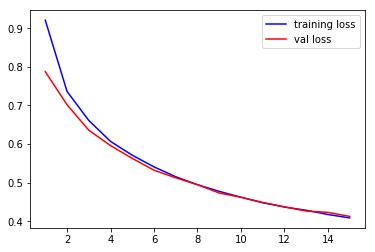

In [36]:
encoder, encoder_opt = get_encoder(66, dropout=0.1)
decoder, decoder_opt = get_decoder(66)

models = (encoder, decoder)
opts = (encoder_opt, decoder_opt)

fit(models, opts, epochs, dataloaders, criterion, scaler)

## Training the seq2seq model with a bidirectional encoder

In [29]:
encoder, encoder_opt = get_encoder(66, dropout=0.4, bidirectional=True)
decoder, decoder_opt = get_decoder(66)

models = (encoder, decoder)
opts = (encoder_opt, decoder_opt)

fit(models, opts, epochs, dataloaders, criterion, scaler, update_learning_rates=update_learning_rates)

Epoch 1/15
15584/15584 [==============================] - Time elapsed: 20.83s - Loss: 0.58017209
Training Loss: 0.92139223 - Val Loss: 0.80178692 - Scaled Val Loss: 0.08680270
Epoch 2/15
15584/15584 [==============================] - Time elapsed: 20.66s - Loss: 0.64399293
Training Loss: 0.75098165 - Val Loss: 0.72032797 - Scaled Val Loss: 0.07225960
Epoch 3/15
15584/15584 [==============================] - Time elapsed: 20.58s - Loss: 0.80740337
Training Loss: 0.68889575 - Val Loss: 0.66978534 - Scaled Val Loss: 0.06467569
Epoch 4/15
15584/15584 [==============================] - Time elapsed: 21.47s - Loss: 0.79325288
Training Loss: 0.64244901 - Val Loss: 0.62834311 - Scaled Val Loss: 0.05889818
Epoch 5/15
15584/15584 [==============================] - Time elapsed: 21.38s - Loss: 0.62221305
Training Loss: 0.60437490 - Val Loss: 0.60324148 - Scaled Val Loss: 0.05547762
Epoch 6/15
15584/15584 [==============================] - Time elapsed: 20.56s - Loss: 0.62537492
Training Loss: 0.

KeyboardInterrupt: 

## Training the seq2seq model with attention

Epoch 1/15
6368/6368 [==============================] - Time: 13.03s - Loss: 0.28657741546630867
Training Loss: 0.3844551008151005 - Val Loss: 0.3059776973724365 - Scaled Val Loss: 0.07617483466081483
Epoch 2/15
6368/6368 [==============================] - Time: 12.89s - Loss: 0.23324629465738933
Training Loss: 0.2792498328178572 - Val Loss: 0.25958847173055016 - Scaled Val Loss: 0.06293677614934134
Epoch 3/15
6368/6368 [==============================] - Time: 12.90s - Loss: 0.24156084060668945
Training Loss: 0.24673716323060207 - Val Loss: 0.2362577997843425 - Scaled Val Loss: 0.056540121402971745
Epoch 4/15
6368/6368 [==============================] - Time: 12.94s - Loss: 0.22435520490010582
Training Loss: 0.22793481641478675 - Val Loss: 0.2206785415013631 - Scaled Val Loss: 0.05197896302965086
Epoch 5/15
6368/6368 [==============================] - Time: 12.93s - Loss: 0.19855694770812987
Training Loss: 0.21371006470429438 - Val Loss: 0.20992007382710776 - Scaled Val Loss: 0.0490761

<Figure size 432x288 with 0 Axes>

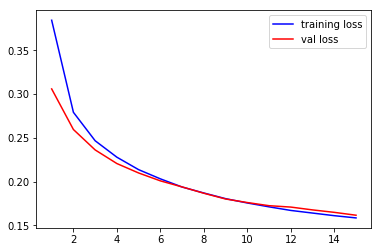

In [78]:
encoder, encoder_opt = get_encoder(66)
decoder, decoder_opt = get_attn_decoder(66, 'general')

models = (encoder, decoder)
opts = (encoder_opt, decoder_opt)

fit(models, opts, epochs, dataloaders, criterion, scaler, use_attention=True)

## Training the seq2seq model with bidirectional encoder and attention

Epoch 1/15
6368/6368 [==============================] - Time: 14.14s - Loss: 0.27742211023966473
Training Loss: 0.3394775181359781 - Val Loss: 0.25211158275604245 - Scaled Val Loss: 0.06133185112066971
Epoch 2/15
6368/6368 [==============================] - Time: 13.87s - Loss: 0.20340992609659832
Training Loss: 0.22660876526505103 - Val Loss: 0.20745236206054693 - Scaled Val Loss: 0.04804651035332627
Epoch 3/15
6368/6368 [==============================] - Time: 13.92s - Loss: 0.17401712735493977
Training Loss: 0.1974703688118326 - Val Loss: 0.18962123648325602 - Scaled Val Loss: 0.04358815335272571
Epoch 4/15
6368/6368 [==============================] - Time: 13.94s - Loss: 0.16357041994730637
Training Loss: 0.18381139189753698 - Val Loss: 0.17921684424082435 - Scaled Val Loss: 0.04059808719323813
Epoch 5/15
6368/6368 [==============================] - Time: 13.90s - Loss: 0.17062155405680338
Training Loss: 0.17437058864925775 - Val Loss: 0.17261907196044923 - Scaled Val Loss: 0.03904

<Figure size 432x288 with 0 Axes>

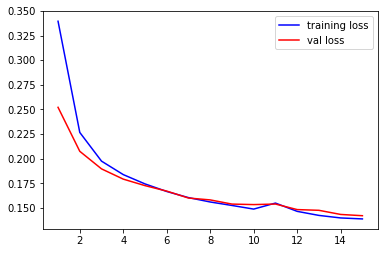

In [79]:
encoder, encoder_opt = get_encoder(66, bidirectional=True)
decoder, decoder_opt = get_attn_decoder(66, 'general', bidirectional_encoder=True)

models = (encoder, decoder)
opts = (encoder_opt, decoder_opt)

fit(models, opts, epochs, dataloaders, criterion, scaler, use_attention=True)